## Тема (рус.): Zero-shot распознавание именованных сущностей
## Тема (анг.): Zero-shot Named Entity Recognition
### Студент: Рафиков Артем Станиславович
### Руководитель: Досов Санжар Музаффарович

Введение в тему "Zero-shot распознование именованных сущностей", для того чтобы приступить к погружению в данную тему, необходимо поставить перед собой цель и задачи для ее достижения. На английском эта тема - "Zero-shot Named Entity Recognition", поэтому далее аббревиатура Named Entity Recognition будет в сокращенном виде - NER.

Цель - Решить задачу NER с частичной разметкой.

Усложненная цель - Решить задачу NER без разметки.

Задачи:
1. Воспроизвести работу релаксированной вариации цели
2. Изучить научные статьи касающиеся тем Few-Shot NER и Zero-Shot NER
3. Воспроизвести архитектуры моделей из предыдущего пункта
4. Применить подходы к разным языкам
5. Сравнить результаты из пункта 4 и NER NATASHA для русской версии датасета CoNLL

### Решаем просто NER:

#### Есть несколько подходов к решению данной задачи:

* Правила
* Нейронные сети
* Комбинированный

#### Области применения NER:

* Быстрое ориентирование в новостях
* Ускорение ответа тех. поддержки
* Продвинутый анализ документации

#### Проблемы NER:

* Двойной смысл слов
* Контекстная зависимость
* Обобщающая способность
* Дизлансные данные
* Языковые особенности

#### Начальный план (релаксированная цель):

* Изучение возможностей spaCy
* Обработка и использование spaCy для NER
* Описание Rule-based подхода
* Проба нейронного подхода, написание своей модели для NER
* Продолжение нейронного подхода, использование bert для NER
* Сравнение результатов

Весь начальный план работает с CoNLL датасетом

Импортируем библиотеки:

In [ ]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import random
import re

import warnings
warnings.filterwarnings('ignore')

## Spacy

In [ ]:
def load_sentences(filepath):

    replace_dict = {' .': '.',
                    ' ,': ',',
                    " '" : "'"}

    final = []
    sentences = []
    raw_text = ''
    text_dict = {}
    id_ = 1

    with open(filepath, 'r') as f:

        for line in f.readlines():

            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    annotations = []
                    final.append(sentences)
                    ent = [(ele.start()-1, ele.end() - 1) for ele in re.finditer(r'\S+', raw_text)]
                    temp_list = []
                    temp_list_2 = []
                    for i in range(len(sentences)):
                        temp_list.append((ent[i][0],ent[i][1],sentences[i][1]))
                        if sentences[i][1] != 'O':
                            temp_list_2.append((ent[i][0],ent[i][1],sentences[i][1]))
                    text_dict[id_] = {'text': raw_text[1:],'annotations':temp_list,'annotations_clear':temp_list_2 }
                    sentences = []
                    id_ += 1
                    raw_text = ''
            else:
                l = line.split(' ')
                raw_text += ' ' + l[0]
                sentences.append((l[0], l[3].strip('\n')))


    return final, text_dict


def save_model(nlp, new_model_name):
    output_dir = 'data/models/'
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir + new_model_name)
        print("Saved model to", output_dir + new_model_name)


def get_training_data(train_df):
    train_data = []
    for index, row in train_df.iterrows():
        annotations = row.annotations_clear
        text = row.text
        train_data.append((text, {"entities": annotations}))
    return train_data


def ner_predict(text,nlp):
    doc = nlp(text)
    preds = []
    for token in doc:
        if token.ent_type_ != '':
            str1 = token.ent_iob_ + ('-' + token.ent_type_ if token.ent_type_ != '' else '')\
                    .replace('NORP','MISC')\
                    .replace('PERSON','PER')
            str2 = token.ent_type_
            preds.append((str(token), str2 if token.ent_type_.find('-') != -1 else str1))
    return preds


def evaluate_model(true_vals,texts_dict, nlp):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    td = texts_dict.copy()
    tv = true_vals.copy()
    for i in tqdm(range(len(td))):
        preds = ner_predict(td[i]['text'],nlp)
        trues = tv[i].copy()
        for el1 in range(len(preds)):
            for el2 in range(len(trues)):
                if (str(trues[el2][0]) == str(preds[el1][0])) & (str(trues[el2][1]) == str(preds[el1][1])):
                    tp += 1
                    break
                elif (str(trues[el2][0]) == str(preds[el1][0])) & (str(trues[el2][1]) != str(preds[el1][1])):
                    fp += 1
                    break
                elif (str(preds[el1][0]) not in [str(ter[0]) for ter in trues]):
                    fn += 1
                    break
                else:
                    tn += 1
                    break

    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }



In [ ]:
base_path = 'data/'

train_samples, train_dict = load_sentences(base_path + 'train.txt')
test_samples, test_dict = load_sentences(base_path + 'test.txt')
valid_samples, valid_dict = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = sorted({tag for sentence in samples
                             for _, tag in sentence})

train_list = list(train_dict.values())
test_list = list(test_dict.values())
valid_list = list(valid_dict.values())

clean_train_samples = [[j for j in i if j[1] != 'O'] for i in train_samples]
clean_test_samples = [[j for j in i if j[1] != 'O'] for i in test_samples]
clean_valid_samples = [[j for j in i if j[1] != 'O'] for i in valid_samples]


In [ ]:
train_samples[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [ ]:
clean_train_samples[0]

[('EU', 'B-ORG'), ('German', 'B-MISC'), ('British', 'B-MISC')]

In [ ]:
counts = dict()
list_lists = [[j[1] for j in i] for i in clean_train_samples]
for i in list_lists:
    for j in i:
        if j in counts.keys():
            counts[j] += 1
        else:
            counts[j] = 1
counts

{'B-ORG': 6321,
 'B-MISC': 3438,
 'B-PER': 6600,
 'I-PER': 4528,
 'B-LOC': 7140,
 'I-ORG': 3704,
 'I-MISC': 1155,
 'I-LOC': 1157}

In [ ]:
train_dict[1]

{'text': 'EU rejects German call to boycott British lamb .',
 'annotations': [(0, 2, 'B-ORG'),
  (3, 10, 'O'),
  (11, 17, 'B-MISC'),
  (18, 22, 'O'),
  (23, 25, 'O'),
  (26, 33, 'O'),
  (34, 41, 'B-MISC'),
  (42, 46, 'O'),
  (47, 48, 'O')],
 'annotations_clear': [(0, 2, 'B-ORG'),
  (11, 17, 'B-MISC'),
  (34, 41, 'B-MISC')]}

In [ ]:
schema

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [ ]:
import spacy
from spacy import displacy
nlp_pt = spacy.load("en_core_web_sm")
doc_pt = nlp_pt(" ".join([v['text'] for v in train_dict.values()][:10]))
nlp_pt.get_pipe("ner").labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

In [ ]:
nlp_pt.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False}},
 'problems': {'tok2vec': [],
  'tagger': [],
  'parser': [],
  'attribute_ruler': [],
  'lemmatizer': [],
  'ner': []},
 'att

In [ ]:
displacy.render(doc_pt, style='ent', jupyter=True)

In [ ]:
evaluate_model(clean_train_samples,train_list,nlp_pt)

100%|███████████████████████████████████████████████████████████████████████████| 14041/14041 [01:05<00:00, 213.13it/s]


{'accuracy': 0.4271961932650073,
 'precision': 0.4929415815448181,
 'recall': 0.13777064955894147,
 'f1_score': 0.21535298836742878}

In [ ]:
evaluate_model(clean_valid_samples,valid_list,nlp_pt)

100%|█████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:15<00:00, 205.93it/s]


{'accuracy': 0.43586358635863587,
 'precision': 0.48123195380173245,
 'recall': 0.1313370107696349,
 'f1_score': 0.20635575732562939}

In [ ]:
evaluate_model(clean_test_samples,test_list,nlp_pt)

100%|█████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:15<00:00, 217.86it/s]


{'accuracy': 0.41417997662641215,
 'precision': 0.4802919708029197,
 'recall': 0.13269696154880345,
 'f1_score': 0.20794269461708628}

In [ ]:
import os
from spacy.util import compounding
from spacy.util import minibatch
from spacy.training.example import Example
from spacy.tokens import DocBin

In [ ]:
def train_ner(nlp,train_data,model_name,batch_size=16):
    for itn in tqdm(range(20)):
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_size)
        losses = {}
        for batch in batches:
            examples = []
            texts, annotations = zip(*batch)
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                examples.append(Example.from_dict(doc, annotations[i]))
            nlp.update(examples, losses=losses, drop=0.3) # drop - снижение запоминания данных

        print("Losses", losses)
    save_model(nlp, model_name)
    return nlp

In [ ]:
nlp = spacy.blank("en")
nlp.add_pipe("ner", last=True)
nlp.pipe_names

['ner']

In [ ]:
train_df = pd.DataFrame(train_dict).T
train_data = get_training_data(train_df)

In [ ]:
train_data[0]

('EU rejects German call to boycott British lamb .',
 {'entities': [(0, 2, 'B-ORG'), (11, 17, 'B-MISC'), (34, 41, 'B-MISC')]})

In [ ]:
nlp.begin_training()
nlp = train_ner(nlp,train_data)
save_model(nlp, 'mine_ner_new')

In [ ]:
nlp_ = spacy.load("data/models/mine_ner_new")

In [ ]:
doc = nlp_(" ".join([v['text'] for v in train_dict.values()][:1000]))

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
nlp_.get_pipe("ner").labels

('B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER')

In [ ]:
nlp_.vocab.length

4269

In [ ]:
nlp_.analyze_pipes()

{'summary': {'ner': {'assigns': ['doc.ents',
    'token.ent_iob',
    'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False}},
 'problems': {'ner': []},
 'attrs': {'doc.ents': {'assigns': ['ner'], 'requires': []},
  'token.ent_type': {'assigns': ['ner'], 'requires': []},
  'token.ent_iob': {'assigns': ['ner'], 'requires': []}}}

In [ ]:
evaluate_model(clean_train_samples,train_list,nlp_)

100%|███████████████████████████████████████████████████████████████████████████| 14041/14041 [00:25<00:00, 551.62it/s]


{'accuracy': 0.9648108185872536,
 'precision': 0.9906616862326574,
 'recall': 0.9087868156971527,
 'f1_score': 0.9479596612910088}

In [ ]:
evaluate_model(clean_valid_samples,valid_list,nlp_)

100%|█████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:05<00:00, 563.90it/s]


{'accuracy': 0.9289357755622537,
 'precision': 0.9128043990573449,
 'recall': 0.8559852670349908,
 'f1_score': 0.8834822277133625}

In [ ]:
evaluate_model(clean_test_samples,test_list,nlp_)

100%|█████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:06<00:00, 537.65it/s]


{'accuracy': 0.8940316686967114,
 'precision': 0.8576879053796261,
 'recall': 0.8189435336976321,
 'f1_score': 0.8378680581438688}

In [ ]:
nlp2 = spacy.blank("en")
nlp2.add_pipe("tok2vec")
nlp2.add_pipe("attribute_ruler").initialize(lambda: [], nlp=nlp2)
nlp2.add_pipe("ner", last=True)
nlp2.pipe_names

['tok2vec', 'attribute_ruler', 'ner']

In [ ]:
nlp2.begin_training()
nlp2 = train_ner(nlp2,train_data,'ner_upd')

In [ ]:
nlp2 = spacy.load("data/models/ner_upd")

In [ ]:
evaluate_model(clean_train_samples,train_list,nlp2)

  0%|                                                                                        | 0/14041 [00:00<?, ?it/s]C:\Users\Artem\anaconda3\lib\site-packages\spacy\pipeline\attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)
100%|███████████████████████████████████████████████████████████████████████████| 14041/14041 [00:47<00:00, 294.71it/s]


{'accuracy': 0.9645547059161732,
 'precision': 0.9895073804019207,
 'recall': 0.9089275504369844,
 'f1_score': 0.9475073438630849}

In [ ]:
evaluate_model(clean_valid_samples,valid_list,nlp2)

100%|█████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:11<00:00, 294.39it/s]


{'accuracy': 0.9307629964107907,
 'precision': 0.9156531973322871,
 'recall': 0.8590357011409643,
 'f1_score': 0.8864413216862893}

In [ ]:
evaluate_model(clean_test_samples,test_list,nlp2)

100%|█████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:11<00:00, 302.15it/s]


{'accuracy': 0.8958764140615497,
 'precision': 0.8655687476062811,
 'recall': 0.8173598553345389,
 'f1_score': 0.8407738095238095}

In [ ]:
nlp_ner = spacy.blank("en")
doc_bin = DocBin()

In [ ]:
from spacy.util import filter_spans

for training_example in tqdm(list(train_dict.values())):
    text = training_example['text']
    labels = training_example['annotations_clear']
    doc = nlp_ner.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("data/training_data.spacy") # save the docbin object

In [ ]:
#!python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
!python -m spacy train config.cfg --output data/ --paths.train data/training_data.spacy --paths.dev data/training_data.spacy

In [ ]:
nlp_ner = spacy.load("data/model-best")

doc = nlp_ner(train_list[0]['text'])

spacy.displacy.render(doc, style="ent", jupyter=True)

In [ ]:
evaluate_model(clean_train_samples,train_list,nlp_ner)

100%|███████████████████████████████████████████████████████████████████████████| 14041/14041 [00:25<00:00, 560.00it/s]


{'accuracy': 0.965889824420242,
 'precision': 0.9921833362941908,
 'recall': 0.9104246474855326,
 'f1_score': 0.9495473286011815}

In [ ]:
evaluate_model(clean_valid_samples,valid_list,nlp_ner)

100%|█████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:05<00:00, 549.29it/s]


{'accuracy': 0.9277038750722961,
 'precision': 0.9206598586017282,
 'recall': 0.8471268521864835,
 'f1_score': 0.8823640127987954}

In [ ]:
evaluate_model(clean_test_samples,test_list,nlp_ner)

100%|█████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:06<00:00, 516.68it/s]


{'accuracy': 0.8924307692307692,
 'precision': 0.860077519379845,
 'recall': 0.8122254758418741,
 'f1_score': 0.8354668674698796}

## NEURO-MODEL

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 799.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=580f9b8aaf7f3973bebe565fc4fd4d560e4b9c0a253e60c41ad09b124270237f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install pytorch-crf

In [ ]:
import datasets

In [ ]:
dataset = datasets.load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
train_samples = dataset['train']['tokens']
valid_samples = dataset['validation']['tokens']
test_samples = dataset['test']['tokens']

In [ ]:
train_samples

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22'],
 ['The',
  'European',
  'Commission',
  'said',
  'on',
  'Thursday',
  'it',
  'disagreed',
  'with',
  'German',
  'advice',
  'to',
  'consumers',
  'to',
  'shun',
  'British',
  'lamb',
  'until',
  'scientists',
  'determine',
  'whether',
  'mad',
  'cow',
  'disease',
  'can',
  'be',
  'transmitted',
  'to',
  'sheep',
  '.'],
 ['Germany',
  "'s",
  'representative',
  'to',
  'the',
  'European',
  'Union',
  "'s",
  'veterinary',
  'committee',
  'Werner',
  'Zwingmann',
  'said',
  'on',
  'Wednesday',
  'consumers',
  'should',
  'buy',
  'sheepmeat',
  'from',
  'countries',
  'other',
  'than',
  'Britain',
  'until',
  'the',
  'scientific',
  'advice',
  'was',
  'clearer',
  '.'],
 ['"',
  'We',
  'do',
  "n't",
  'support',
  'any',
  'such',
  'recommendation',
  'because',
  'we',
  'do',
  "n't",
  'see',
  'any',
  'grounds',
  'fo

In [ ]:
print(f"Максимальная длина предложения на обучающей {max([len(item) for item in train_samples])}")
print(f"Максимальная длина предложения на валидационной {max([len(item) for item in valid_samples])}")
print(f"Максимальная длина предложения на тестовой {max([len(item) for item in test_samples])}")

Максимальная длина предложения на обучающей 113
Максимальная длина предложения на валидационной 109
Максимальная длина предложения на тестовой 124


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as Data
from collections import defaultdict

In [ ]:
words_counts = defaultdict(int)
for line in train_samples:
    for word in line:
        words_counts[word] += 1
rare_words = []
for k,v in words_counts.items():
    if v < 2:
        rare_words.append(k)
for word in rare_words:
    del words_counts[word]
words_counts['<UNK>'] = 1
words_counts['<PAD>'] = 1
word2id = {}
id2word = {}
for idx, word in enumerate(words_counts.keys()):
    word2id[word] = idx
    id2word[idx] = word

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs


class ColnnDataset(Data):
    def __init__(self, df):
        self.texts = df['tokens']
        self.labels = df['ner_tags']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }


In [ ]:
def custom_collate_fn(batch):
    output = dict()
    output["input_ids"] = [sample["input_ids"] for sample in batch]

    output["labels"] = [sample["labels"] for sample in batch]

    # calculate max token length of this batch
    batch_max = max([len(ids) for ids in output["input_ids"]])

    # add padding

    output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]

    output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

    # convert to tensors
    output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)

    output["labels"] = torch.tensor(output["labels"], dtype=torch.long)
    return output

In [ ]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [ ]:
def recover_id2label(id2label, pred, truth):
    label_truth = []
    label_pred = []
    for i in range(len(truth)):
        cur_pred = []
        cur_truth = []
        for j in range(len(truth[i])):
            if truth[i][j] == -100:
                pass
            else:
                cur_truth.append(id2label[str(truth[i][j])])
                if j < len(pred[i]) and str(pred[i][j]) in id2label  :
                    cur_pred.append(id2label[str(pred[i][j])])
                else:
                    cur_pred.append('O')
        label_truth.append(cur_truth)
        label_pred.append(cur_pred)
    return label_pred, label_truth

In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, LSTM_CFG):
        super(LSTMModel, self).__init__()
        self.config = LSTM_CFG
        self.word_embeddings = nn.Embedding(self.config.vocab_size, self.config.hidden_size)
        self.bilstm = nn.LSTM(self.config.hidden_size, self.config.hidden_size, num_layers=2,
                              dropout=self.config.hidden_dropout_prob, batch_first=True,
                              bidirectional=True)
        self.fc = nn.Linear(self.config.hidden_size*2,9)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
#         bilstm
        lstm_out, (hidden_last,cn_last) = self.bilstm(embeds)
#        lstm_out  [batch_size, seq_length, 2*hidden_size]
        return self.fc(lstm_out)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CFG:
    apex = True
    seed = 42
    max_len = 128
    dropout = 0.2
    n_accumulate = 1
    print_freq = 100
    min_lr = 1e-6
    eps = 1e-6
    betas = (0.9, 0.999)
    scheduler = 'cosine'
    batch_size = 128
    num_workers = 8
    lr = 0.02
    weight_decay = 0.01
    epochs = 10
    train = True
    test = True
    num_warmup_steps = 0
    num_cycles = 0.5
    encoder_lr = 0.02
    decoder_lr = 0.02
    freezing = False
    debug = False
    gradient_checkpoint = False


In [ ]:
from tqdm import tqdm
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, criterion):
    model.train()

    dataset_size = 0
    running_loss = 0
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)

    for step, data in enumerate(tqdm(dataloader)):
        ids = data['input_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device, dtype=torch.long)

        batch_size = ids.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            outputs = model(ids)
        loss = criterion(outputs.view(-1,9), labels.view(-1))

        # accumulate
        loss = loss / CFG.n_accumulate
        scaler.scale(loss).backward()
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
    return epoch_loss

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, criterion):
    model.eval()

    dataset_size = 0
    running_loss = 0

    pred = []
    ground_truth = []
    for step, data in enumerate(tqdm(dataloader)):
        ids = data['input_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device, dtype=torch.long)

        batch_size = ids.size(0)
        outputs = model(ids)

        loss = criterion(outputs.view(-1,9), labels.view(-1))
        pred.extend(outputs.to('cpu').numpy().argmax(-1))
        ground_truth.extend(labels.to('cpu').numpy())

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

    pred = np.array(pred)
    ground_truth = np.array(ground_truth)
    return epoch_loss, pred, ground_truth

In [ ]:
class LSTM_CFG:
    hidden_size = 256
    hidden_dropout_prob = 0.3
    vocab_size =  len(word2id)

In [ ]:
from transformers import get_cosine_schedule_with_warmup
from torch.optim import AdamW
import numpy as np
from seqeval.metrics import f1_score, classification_report
def train_loop():
    train_dataset = ColnnDataset(dataset['train'])
    valid_dataset = ColnnDataset(dataset['validation'])

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              collate_fn=custom_collate_fn,
                              num_workers=CFG.num_workers,
                              pin_memory=True,
                              drop_last=False)

    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              collate_fn=custom_collate_fn,
                              num_workers=CFG.num_workers,
                              pin_memory=True,
                              drop_last=False)

    model = LSTMModel(LSTM_CFG)
    model.to(device)



    optimizer_parameters = [{'params': [p for n, p in model.named_parameters() if "model" not in n], 'lr':CFG.decoder_lr, "weight_decay": 0.0}]

    optimizer = AdamW(optimizer_parameters, lr=CFG.lr, eps=CFG.eps, betas=CFG.betas)

    num_train_steps = int(len(train_dataset) / CFG.batch_size * CFG.epochs)
    scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps,
            num_cycles=CFG.num_cycles
        )
    criterion = nn.CrossEntropyLoss()

    # loop
    best_score = float('-inf')

    for epoch in range(CFG.epochs):

        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch, criterion)

        valid_epoch_loss, pred, ground_truth = valid_one_epoch(model, valid_loader, device, epoch, criterion)

        label_pred, label_truth = recover_id2label(id2label, pred, ground_truth)
        score = f1_score(label_truth, label_pred)
        print("EPOCH: ", epoch + 1)
        print("avg_train_loss: ", train_epoch_loss)
        print("avg_val_loss: ", valid_epoch_loss)
        print("F1-score: ", score)

    torch.save(model.state_dict(), "model_ner.pt")
    torch.cuda.empty_cache()


In [ ]:
train_loop()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/

EPOCH:  1
avg_train_loss:  0.6024806920080034
avg_val_loss:  0.2604615486401778
F1-score:  0.5543347797987259


100%|██████████| 26/26 [00:01<00:00, 21.02it/s]


EPOCH:  2
avg_train_loss:  0.16649000913479942
avg_val_loss:  0.15664106801839975
F1-score:  0.758479114601928


100%|██████████| 26/26 [00:00<00:00, 28.04it/s]


EPOCH:  3
avg_train_loss:  0.07997861196152395
avg_val_loss:  0.13683246104533855
F1-score:  0.7998571683627924


100%|██████████| 26/26 [00:00<00:00, 39.41it/s]


EPOCH:  4
avg_train_loss:  0.04870545155183091
avg_val_loss:  0.1341762332732861
F1-score:  0.8031961090845926


100%|██████████| 26/26 [00:00<00:00, 41.05it/s]


EPOCH:  5
avg_train_loss:  0.03048082080952726
avg_val_loss:  0.13854661250114442
F1-score:  0.8206123709520868


100%|██████████| 26/26 [00:00<00:00, 40.56it/s]


EPOCH:  6
avg_train_loss:  0.02078798328163566
avg_val_loss:  0.14353854808440575
F1-score:  0.8177770016589541


100%|██████████| 26/26 [00:00<00:00, 40.47it/s]


EPOCH:  7
avg_train_loss:  0.014340427252788012
avg_val_loss:  0.15729385531865633
F1-score:  0.8241294407316215


100%|██████████| 26/26 [00:00<00:00, 38.66it/s]


EPOCH:  8
avg_train_loss:  0.011383814363769635
avg_val_loss:  0.15271185770401588
F1-score:  0.8240380458279293


100%|██████████| 26/26 [00:00<00:00, 40.95it/s]


EPOCH:  9
avg_train_loss:  0.00913240488298377
avg_val_loss:  0.15212955755453844
F1-score:  0.8233479043455902


100%|██████████| 26/26 [00:00<00:00, 29.49it/s]


EPOCH:  10
avg_train_loss:  0.008826012744174097
avg_val_loss:  0.15483710432052614
F1-score:  0.8247156153050672


In [ ]:
model = LSTMModel(LSTM_CFG)
model_ner_chk = torch.load("model_ner.pt", map_location=torch.device('cpu'))

In [ ]:
model.load_state_dict(model_ner_chk)

<All keys matched successfully>

In [ ]:
test_dataset = ColnnDataset(dataset['test'])
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=CFG.num_workers,
                         pin_memory=True,
                         drop_last=False)

In [ ]:
model.eval()
pred = []
ground_truth = []
device = torch.device('cpu')
for step, data in enumerate(tqdm(test_loader)):
    ids = data['input_ids'].to(device, dtype=torch.long)
    labels = data['labels'].to(device, dtype=torch.long)

    outputs = model(ids)

    pred.extend(outputs.detach().numpy().argmax(-1))
    ground_truth.extend(labels.detach().numpy())


pred = np.array(pred)
ground_truth = np.array(ground_truth)



100%|██████████| 27/27 [00:19<00:00,  1.38it/s]
<ipython-input-42-dbb2595474eb>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred = np.array(pred)
<ipython-input-42-dbb2595474eb>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ground_truth = np.array(ground_truth)


In [ ]:
label_pred, label_truth = recover_id2label(id2label, pred, ground_truth)
score = f1_score(label_truth, label_pred)
print("F1-score: ", score)

F1-score:  0.7280036546368205


In [ ]:
print(classification_report(label_truth, label_pred))

              precision    recall  f1-score   support

         LOC       0.83      0.81      0.82      1668
        MISC       0.66      0.66      0.66       702
         ORG       0.70      0.67      0.68      1661
         PER       0.76      0.66      0.71      1617

   micro avg       0.75      0.71      0.73      5648
   macro avg       0.74      0.70      0.72      5648
weighted avg       0.75      0.71      0.73      5648



## Bert models

In [ ]:
from datasets import load_dataset
conll = load_dataset('conll2003')
label_names = conll["train"].features["ner_tags"].feature.names

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_adjust_labels(all_samples_per_split):
    tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True)
    total_adjusted_labels = []
    #print(len(tokenized_samples["input_ids"]))
    for k in range(0, len(tokenized_samples["input_ids"])):
        prev_wid = -1
        word_ids_list = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = all_samples_per_split["ner_tags"][k]
        i = -1
        adjusted_label_ids = []

        for wid in word_ids_list:
            if(wid is None):
                adjusted_label_ids.append(-100)
            elif(wid!=prev_wid):
                i = i + 1
                adjusted_label_ids.append(existing_label_ids[i])
                prev_wid = wid
            else:
                label_name = label_names[existing_label_ids[i]]
                adjusted_label_ids.append(existing_label_ids[i])

        total_adjusted_labels.append(adjusted_label_ids)
    tokenized_samples["labels"] = total_adjusted_labels
    return tokenized_samples

tokenized_dataset = conll.map(tokenize_adjust_labels, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    for k in results.keys():
        if(k not in flattened_results.keys()):
            flattened_results[k+"_f1"]=results[k]["f1"]

    return flattened_results

<ipython-input-10-0a54798cebde>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import os
#os.environ['WANDB_DISABLED'] = 'True'
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_names))
training_args = TrainingArguments(
    output_dir="./fine_tune_bert_output",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_steps = 1000,
    run_name = "ep_10_tokenized_11",
    save_strategy='no'
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Loc F1,Misc F1,Org F1,Per F1
1000,0.156400,0.070079,0.920316,0.929481,0.924876,0.981913,0.956008,0.834195,0.895752,0.955026
2000,0.043200,0.071745,0.933047,0.935223,0.934134,0.983693,0.961014,0.856378,0.907361,0.962760
3000,0.022400,0.066354,0.937852,0.942311,0.940076,0.984959,0.960366,0.863333,0.921458,0.968259
4000,0.014300,0.066255,0.939626,0.946707,0.943153,0.985739,0.962264,0.861343,0.930722,0.969050
5000,0.008000,0.072721,0.936498,0.948681,0.942550,0.985504,0.961790,0.866317,0.925032,0.971103
6000,0.004800,0.072484,0.940935,0.947605,0.944258,0.986033,0.964286,0.871676,0.926659,0.969634


TrainOutput(global_step=6146, training_loss=0.0406085657512874, metrics={'train_runtime': 1159.2644, 'train_samples_per_second': 84.784, 'train_steps_per_second': 5.302, 'total_flos': 2456601677028378.0, 'train_loss': 0.0406085657512874, 'epoch': 7.0})

In [ ]:
trainer.predict(tokenized_dataset["test"])

PredictionOutput(predictions=array([[[ 9.1996279e+00, -6.5521605e-02, -1.8845313e+00, ...,
         -8.9376318e-01, -1.0669162e+00, -1.2113280e+00],
        [ 1.0123908e+01, -3.6723707e-02, -2.1863937e+00, ...,
         -1.0959375e+00, -1.7701291e+00, -1.3710586e+00],
        [ 1.0528492e+01, -4.8524860e-01, -2.0637615e+00, ...,
         -9.6605551e-01, -2.2643518e+00, -1.4610400e+00],
        ...,
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]],

       [[ 7.5210428e+00,  7.8796536e-01, -1.3814458e+00, ...,
         -1.5391710e+00, -7.7851564e-01, -1.0561413e+00],
        [-1.3936886e+00,  9.5966949e+00, -1.1628957e+00, ...,
         -1.6863836e+00, -6.0588884e-01, -9.5719588e-0

In [ ]:
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.22125586867332458,
 'eval_overall_precision': 0.894828216374269,
 'eval_overall_recall': 0.9085258372761852,
 'eval_overall_f1': 0.9016250057542697,
 'eval_overall_accuracy': 0.9717306692299207,
 'eval_LOC_f1': 0.9188473004306061,
 'eval_MISC_f1': 0.7441130298273154,
 'eval_ORG_f1': 0.9077974612916725,
 'eval_PER_f1': 0.9440348525469168,
 'eval_runtime': 14.075,
 'eval_samples_per_second': 245.329,
 'eval_steps_per_second': 15.346,
 'epoch': 7.0}

## Читаем статью
https://arxiv.org/pdf/2210.07022.pdf

В исследовательской статье под названием "CROP: Межъязыковое распознавание именованных объектов с нулевым кадром и переводом многоязычной последовательности с маркировкой" обсуждается сложная проблема межъязыкового распознавания именованных объектов с нулевым кадром (NER), целью которого является передача знаний с языков-источников с высоким ресурсом на языки-мишени с низким ресурсом без каких-либо маркированных последовательностей. данные. В документе представлена структура межъязыковой проекции сущностей (CROP), которая использует многоязычный перевод последовательности с маркировкой, основанный на информации о выравнивании на уровне фраз, для передачи знаний между разными языками. Экспериментальные результаты демонстрируют, что предложенный метод позволяет достичь самых современных результатов в тестах и улучшает переносимость с исходного языка почти на 39 целевых языков.

В документе также обсуждаются методы передачи на основе моделей и данных для межъязыкового NER, включая использование межъязыковых предварительно обученных языковых моделей и многоязычный перевод последовательности с маркировкой для повышения производительности. Кроме того, в статье дается представление о влиянии размера обучающих данных и качестве перевода с пометкой, а также проводится сравнение с предыдущими современными методами межъязыкового перевода с нулевыми ресурсами.

В целом, в документе представлена всеобъемлющая структура для решения сложной проблемы межъязыкового NER с нулевым результатом и демонстрируется эффективность предлагаемого метода CROP в улучшении межъязыковой передачи знаний.

Архитектура основной модели для распознавания именованных объектов (NER) состоит из кодера и линейного классификатора. Кодер, представленный параметром ΘE, извлекает объекты верхнего уровня из входного предложения.Затем эти признаки передаются в линейный классификатор с функцией softmax для генерации распределения вероятностей каждого входного слова. Параметры модели базовой модели NER обозначаются как ΘNer = {Wc, bc}.Эта архитектура позволяет модели идентифицировать объекты и присваивать им предопределенные типы. Конкретные детали архитектуры можно найти в разделе "Базовая модель 3.2 для NER" документа на странице 3.

Для эффективного выполнения межъязыковой проекции вы можете использовать фреймворк Cross-lingual Entity Projection (CROP), как описано в исследовательской статье под названием "CROP: Распознавание межъязыковых именованных сущностей с нулевым кадром с переводом последовательности с многоязычной маркировкой" Цзянь Янга и др. Платформа CROP использует многоязычный перевод последовательности с маркировкой, управляемый несколькими двуязычными корпусами и соответствующей информацией о выравнивании на уровне фраз.

Кроме того, вы можете обратиться к странице 3 документа для получения подробной информации о переводе помеченной последовательности, а также к странице 9, где подробно описывается межъязыковая проекция объекта. Если вам нужно более глубокое понимание, я предлагаю углубиться в исследовательскую работу, чтобы получить исчерпывающее представление о реализации межъязыковой проекции.

Ссылка на GIT авторов статьи https://github.com/YuweiYin/CROP/tree/master

In [1]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('/content/xlm_roberta_base_eval_logs_agg.txt') as file:
    #lines = [line.rstrip() for line in file]
    base_lines = [{line.split('\t')[0]:ast.literal_eval(line.split('\t')[1].rstrip())} for line in file]
    print(base_lines)

[{'1000': {'loss': 1.285059, 'dev_en': {'precision': 0.059905543127019636, 'recall': 0.03907580056749088, 'f1': 0.047298954908983865}, 'test_en': {'precision': 0.052479959919839676, 'recall': 0.03440913197010758, 'f1': 0.041565398541739004}}}, {'2000': {'loss': 0.840264, 'dev_en': {'precision': 0.3906912034402074, 'recall': 0.5008512363194163, 'f1': 0.43896546823930654}, 'test_en': {'precision': 0.37915379279904154, 'recall': 0.49379978648271333, 'f1': 0.42894849479240976}}}, {'3000': {'loss': 0.428459, 'dev_en': {'precision': 0.7317611777535441, 'recall': 0.8325091203891366, 'f1': 0.7777761321138963}, 'test_en': {'precision': 0.7082588681288925, 'recall': 0.8165722263283239, 'f1': 0.7572006382426065}}}, {'4000': {'loss': 0.30916, 'dev_en': {'precision': 0.7752587344585679, 'recall': 0.8714227807053101, 'f1': 0.8196319018404908}, 'test_en': {'precision': 0.7584756898817346, 'recall': 0.8631354192329802, 'f1': 0.8063222706112029}}}, {'5000': {'loss': 0.279912, 'dev_en': {'precision': 0.

In [4]:
with open('/content/xlm_roberta_large_eval_logs_agg.txt') as file:
    #lines = [line.rstrip() for line in file]
    large_lines = [{line.split('\t')[0]:ast.literal_eval(line.split('\t')[1].rstrip())} for line in file]
    print(large_lines)

[{'3500': {'loss': 0.277507, 'dev_en': {'precision': 0.4087345367745214, 'recall': 0.4264521890657345, 'f1': 0.4181235668867574}, 'test_en': {'precision': 0.4154343637666886, 'recall': 0.428658657568688, 'f1': 0.4197867764546565}}}, {'7000': {'loss': 0.263485, 'dev_en': {'precision': 0.7056474566555664, 'recall': 0.7278455663234545, 'f1': 0.7164662134455234}, 'test_en': {'precision': 0.7165474564645624, 'recall': 0.736545676756554, 'f1': 0.7245665647566754}}}, {'10500': {'loss': 0.246586, 'dev_en': {'precision': 0.8071897684064985, 'recall': 0.8253923370564117, 'f1': 0.8161895774352522}, 'test_en': {'precision': 0.8068413289316569, 'recall': 0.822909950569525, 'f1': 0.8147964250248262}}}, {'14000': {'loss': 0.207297, 'dev_en': {'precision': 0.8161754236081447, 'recall': 0.8104057684150997, 'f1': 0.8132803632236096}, 'test_en': {'precision': 0.8122699386503067, 'recall': 0.8062182104735296, 'f1': 0.8092327604803335}}}, {'17500': {'loss': 0.168861, 'dev_en': {'precision': 0.8112717574396

In [6]:
base_correct = dict()
large_correct = dict()
for i in base_lines:
  base_correct = dict(list(base_correct.items()) + list(i.items()))
for i in large_lines:
  large_correct = dict(list(large_correct.items()) + list(i.items()))

In [7]:
base_losses = {k:v['loss'] for k,v in base_correct.items()}
large_losses = {k:v['loss'] for k,v in large_correct.items()}

base_dev_en_precision = {k:v['dev_en']['precision'] for k,v in base_correct.items()}
base_dev_en_recall = {k:v['dev_en']['recall'] for k,v in base_correct.items()}
base_dev_en_f1 = {k:v['dev_en']['f1'] for k,v in base_correct.items()}

base_test_en_precision = {k:v['test_en']['precision'] for k,v in base_correct.items()}
base_test_en_recall = {k:v['test_en']['recall'] for k,v in base_correct.items()}
base_test_en_f1 = {k:v['test_en']['f1'] for k,v in base_correct.items()}

large_dev_en_precision = {k:v['dev_en']['precision'] for k,v in large_correct.items()}
large_dev_en_recall = {k:v['dev_en']['recall'] for k,v in large_correct.items()}
large_dev_en_f1 = {k:v['dev_en']['f1'] for k,v in large_correct.items()}

large_test_en_precision = {k:v['test_en']['precision'] for k,v in large_correct.items()}
large_test_en_recall = {k:v['test_en']['recall'] for k,v in large_correct.items()}
large_test_en_f1 = {k:v['test_en']['f1'] for k,v in large_correct.items()}


In [8]:
base_data_losses = pd.DataFrame(base_losses.items()).rename(columns={0: 'global_step', 1: 'loss'})

base_data_dev_en_precision = pd.DataFrame(base_dev_en_precision.items()).rename(columns={0: 'global_step', 1: 'precision'})
base_data_dev_en_recall = pd.DataFrame(base_dev_en_recall.items()).rename(columns={0: 'global_step', 1: 'recall'})
base_data_dev_en_f1 = pd.DataFrame(base_dev_en_f1.items()).rename(columns={0: 'global_step', 1: 'f1'})

base_data_test_en_precision = pd.DataFrame(base_test_en_precision.items()).rename(columns={0: 'global_step', 1: 'precision'})
base_data_test_en_recall = pd.DataFrame(base_test_en_recall.items()).rename(columns={0: 'global_step', 1: 'recall'})
base_data_test_en_f1 = pd.DataFrame(base_test_en_f1.items()).rename(columns={0: 'global_step', 1: 'f1'})

large_data_losses = pd.DataFrame(large_losses.items()).rename(columns={0: 'global_step', 1: 'loss'})

large_data_dev_en_precision = pd.DataFrame(large_dev_en_precision.items()).rename(columns={0: 'global_step', 1: 'precision'})
large_data_dev_en_recall = pd.DataFrame(large_dev_en_recall.items()).rename(columns={0: 'global_step', 1: 'recall'})
large_data_dev_en_f1 = pd.DataFrame(large_dev_en_f1.items()).rename(columns={0: 'global_step', 1: 'f1'})

large_data_test_en_precision = pd.DataFrame(large_test_en_precision.items()).rename(columns={0: 'global_step', 1: 'precision'})
large_data_test_en_recall = pd.DataFrame(large_test_en_recall.items()).rename(columns={0: 'global_step', 1: 'recall'})
large_data_test_en_f1 = pd.DataFrame(large_test_en_f1.items()).rename(columns={0: 'global_step', 1: 'f1'})

### base model

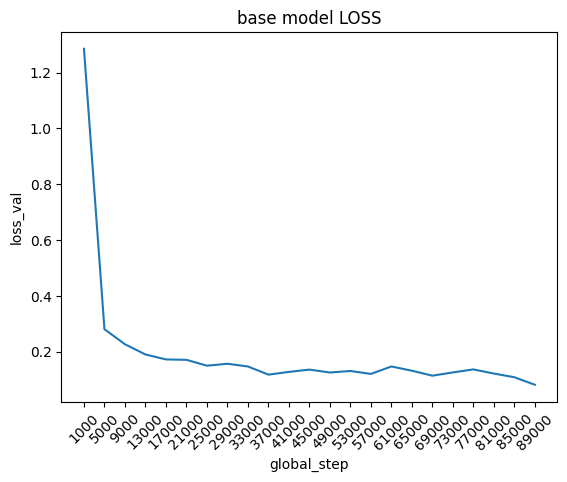

In [9]:
plt.plot(base_data_losses[base_data_losses['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base model LOSS');
plt.xlabel('global_step');
plt.ylabel('loss_val');
plt.xticks(rotation=45);

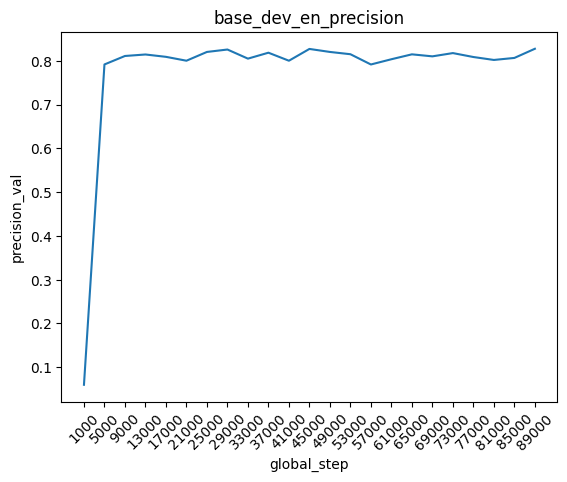

In [10]:
plt.plot(base_data_dev_en_precision[base_data_dev_en_precision['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_dev_en_precision');
plt.xlabel('global_step');
plt.ylabel('precision_val');
plt.xticks(rotation=45);

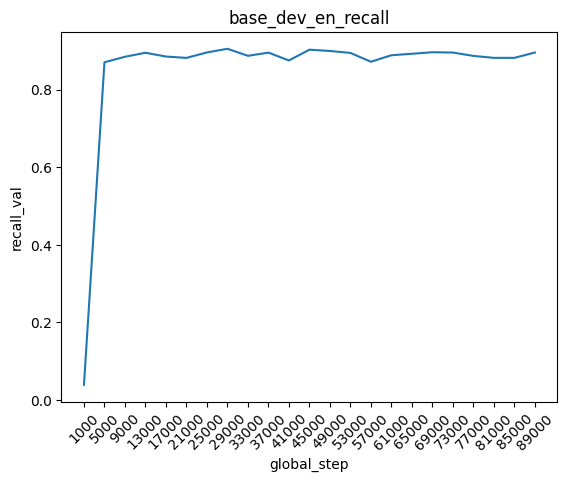

In [11]:
plt.plot(base_data_dev_en_recall[base_data_dev_en_recall['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_dev_en_recall');
plt.xlabel('global_step');
plt.ylabel('recall_val');
plt.xticks(rotation=45);

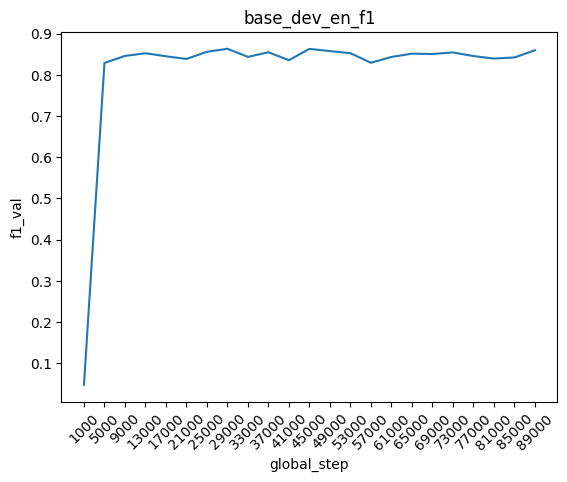

In [12]:
plt.plot(base_data_dev_en_f1[base_data_dev_en_f1['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_dev_en_f1');
plt.xlabel('global_step');
plt.ylabel('f1_val');
plt.xticks(rotation=45);

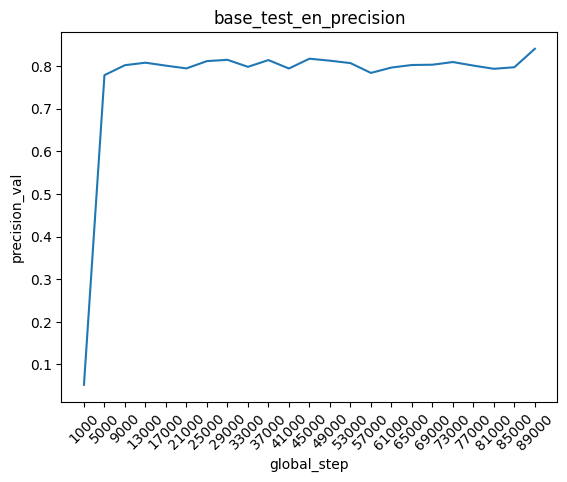

In [13]:
plt.plot(base_data_test_en_precision[base_data_test_en_precision['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_test_en_precision');
plt.xlabel('global_step');
plt.ylabel('precision_val');
plt.xticks(rotation=45);

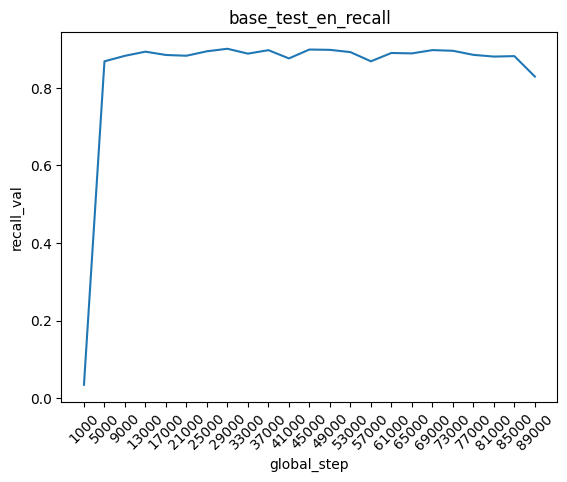

In [14]:
plt.plot(base_data_test_en_recall[base_data_test_en_recall['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_test_en_recall');
plt.xlabel('global_step');
plt.ylabel('recall_val');
plt.xticks(rotation=45);

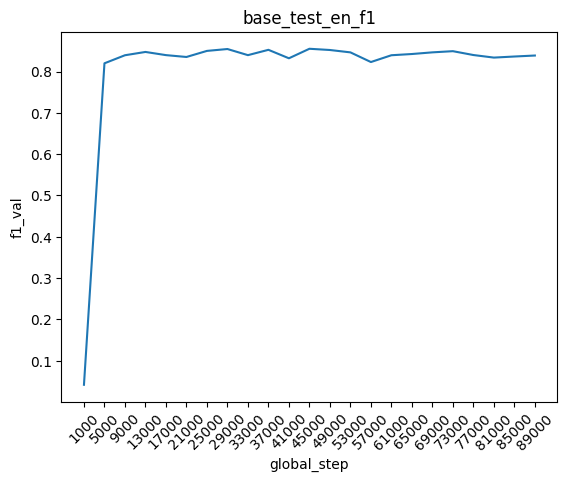

In [15]:
plt.plot(base_data_test_en_f1[base_data_test_en_f1['global_step'].astype(int)/1000 % 4 == 1].set_index('global_step'));
plt.title('base_test_en_f1');
plt.xlabel('global_step');
plt.ylabel('f1_val');
plt.xticks(rotation=45);

### large model

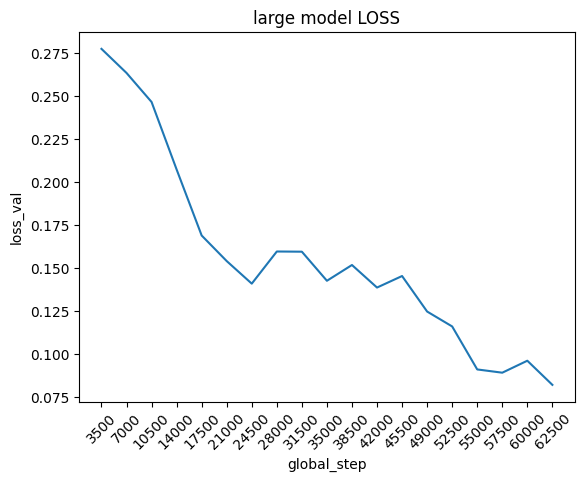

In [17]:
plt.plot(large_data_losses.set_index('global_step'));
plt.title('large model LOSS');
plt.xlabel('global_step');
plt.ylabel('loss_val');
plt.xticks(rotation=45);

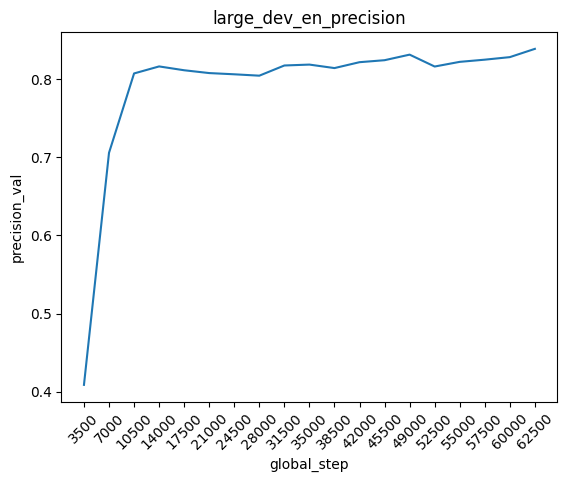

In [18]:
plt.plot(large_data_dev_en_precision.set_index('global_step'));
plt.title('large_dev_en_precision');
plt.xlabel('global_step');
plt.ylabel('precision_val');
plt.xticks(rotation=45);

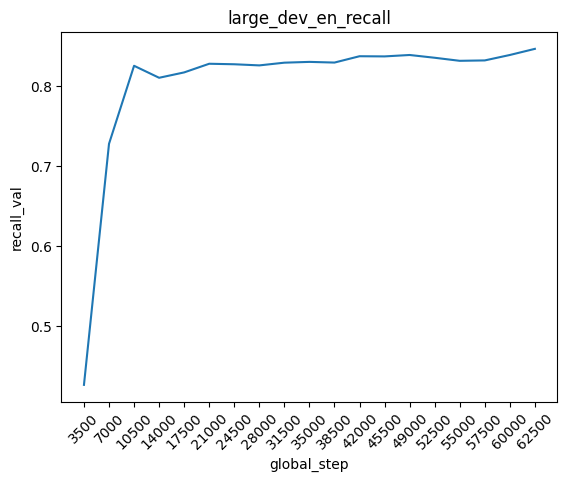

In [19]:
plt.plot(large_data_dev_en_recall.set_index('global_step'));
plt.title('large_dev_en_recall');
plt.xlabel('global_step');
plt.ylabel('recall_val');
plt.xticks(rotation=45);

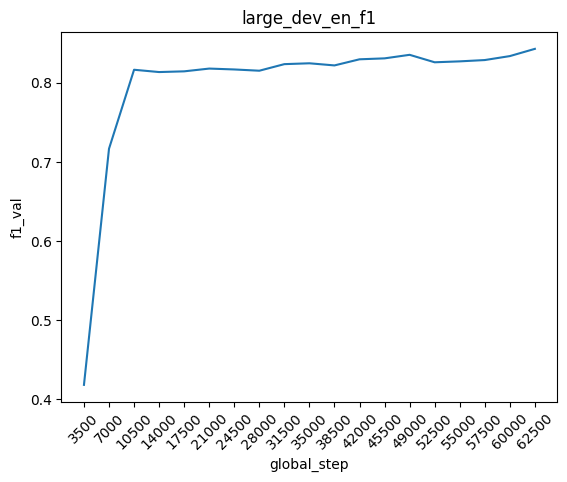

In [20]:
plt.plot(large_data_dev_en_f1.set_index('global_step'));
plt.title('large_dev_en_f1');
plt.xlabel('global_step');
plt.ylabel('f1_val');
plt.xticks(rotation=45);

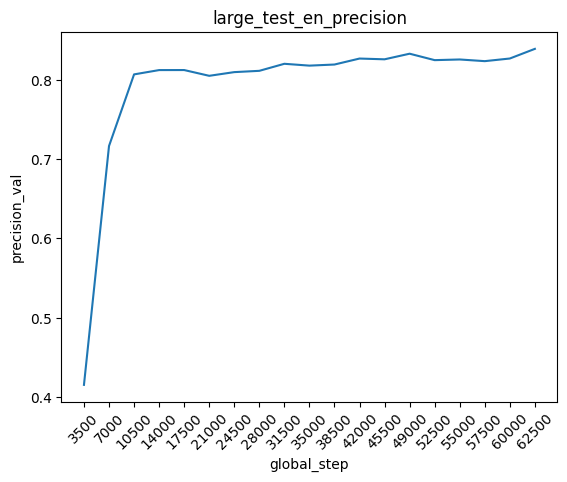

In [21]:
plt.plot(large_data_test_en_precision.set_index('global_step'));
plt.title('large_test_en_precision');
plt.xlabel('global_step');
plt.ylabel('precision_val');
plt.xticks(rotation=45);

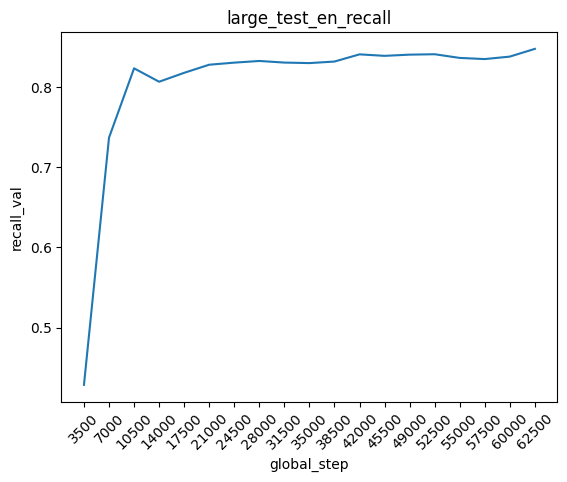

In [22]:
plt.plot(large_data_test_en_recall.set_index('global_step'));
plt.title('large_test_en_recall');
plt.xlabel('global_step');
plt.ylabel('recall_val');
plt.xticks(rotation=45);

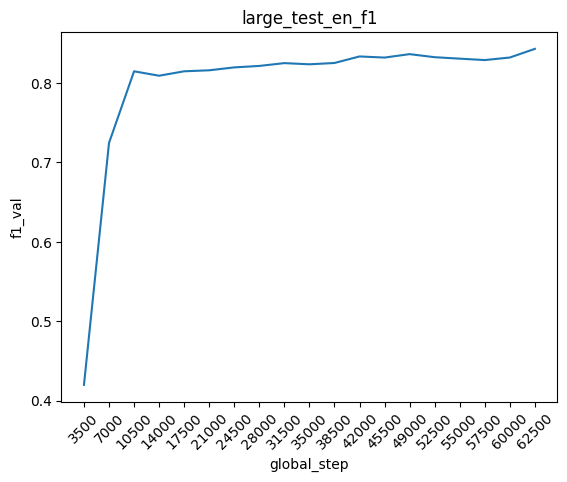

In [23]:
plt.plot(large_data_test_en_f1.set_index('global_step'));
plt.title('large_test_en_f1');
plt.xlabel('global_step');
plt.ylabel('f1_val');
plt.xticks(rotation=45);

In [ ]:
import pandas as pd

In [ ]:
data_info = pd.read_excel('/content/data_info.xlsx')
data_info

,Выборка,B-ORG,B-MISC,B-PER,B-LOC,I-ORG,I-MISC,I-PER,I-LOC
0,train.txt,6321,3438,6600,7140,3704,1155,4528,1157
1,valid.txt,1341,922,1842,1837,751,346,1307,257
2,test.txt,1661,702,1617,1668,835,216,1156,257


In [ ]:
data_info.drop('Выборка', axis=1, inplace= True)

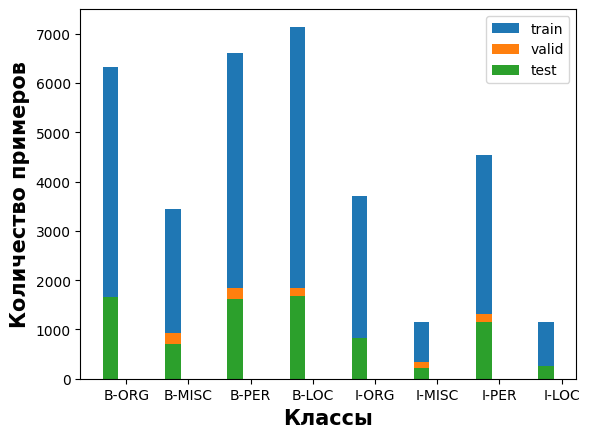

In [ ]:
plt.bar(x=data_info.columns, height=data_info.loc[0],width=0.25,label ='train')
plt.bar(x=data_info.columns, height=data_info.loc[1],width=0.25,label ='valid')
plt.bar(x=data_info.columns, height=data_info.loc[2],width=0.25,label ='test')
plt.xlabel('Классы', fontweight ='bold', fontsize = 15)
plt.ylabel('Количество примеров', fontweight ='bold', fontsize = 15)
plt.xticks([r + 0.25 for r in range(len(data_info.columns))],
        data_info.columns)
plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import random
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_sentences(filepath):

    replace_dict = {' .': '.',
                    ' ,': ',',
                    " '" : "'"}

    final = []
    sentences = []
    raw_text = ''
    text_dict = {}
    id_ = 1

    with open(filepath, 'r') as f:

        for line in f.readlines():

            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    annotations = []
                    final.append(sentences)
                    ent = [(ele.start()-1, ele.end() - 1) for ele in re.finditer(r'\S+', raw_text)]
                    temp_list = []
                    temp_list_2 = []
                    for i in range(len(sentences)):
                        temp_list.append((ent[i][0],ent[i][1],sentences[i][1]))
                        if sentences[i][1] != 'O':
                            temp_list_2.append((ent[i][0],ent[i][1],sentences[i][1]))
                    text_dict[id_] = {'text': raw_text[1:],'annotations':temp_list,'annotations_clear':temp_list_2 }
                    sentences = []
                    id_ += 1
                    raw_text = ''
            else:
                l = line.split('\t')
                raw_text += ' ' + l[0]
                sentences.append((l[0], l[1].strip('\n')))


    return final, text_dict


def save_model(nlp, new_model_name):
    output_dir = '/content/drive/MyDrive/diplom_colab/'
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir + new_model_name)
        print("Saved model to", output_dir + new_model_name)


def get_training_data(train_df):
    train_data = []
    for index, row in train_df.iterrows():
        annotations = row.annotations_clear
        text = row.text
        train_data.append((text, {"entities": annotations}))
    return train_data


def ner_predict(text,nlp):
    doc = nlp(text)
    preds = []
    for token in doc:
        if token.ent_type_ != '':
            str1 = token.ent_iob_ + ('-' + token.ent_type_ if token.ent_type_ != '' else '')\
                    .replace('NORP','MISC')\
                    .replace('PERSON','PER')
            str2 = token.ent_type_
            preds.append((str(token), str2 if token.ent_type_.find('-') != -1 else str1))
    return preds


def evaluate_model(true_vals,texts_dict, nlp):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    td = texts_dict.copy()
    tv = true_vals.copy()
    for i in tqdm(range(len(td))):
        preds = ner_predict(td[i]['text'],nlp)
        trues = tv[i].copy()
        for el1 in range(len(preds)):
            for el2 in range(len(trues)):
                if (str(trues[el2][0]) == str(preds[el1][0])) & (str(trues[el2][1]) == str(preds[el1][1])):
                    tp += 1
                    break
                elif (str(trues[el2][0]) == str(preds[el1][0])) & (str(trues[el2][1]) != str(preds[el1][1])):
                    fp += 1
                    break
                elif (str(preds[el1][0]) not in [str(ter[0]) for ter in trues]):
                    fn += 1
                    break
                else:
                    tn += 1
                    break

    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import spacy
from spacy import displacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy.training.example import Example
from spacy.tokens import DocBin

In [5]:
base_path = '/content/drive/MyDrive/diplom_colab/'
lang = 'ru'

train_samples, train_dict = load_sentences(base_path + f'train-{lang}.tsv')
test_samples, test_dict = load_sentences(base_path + f'test-{lang}.xlmr')
valid_samples, valid_dict = load_sentences(base_path + f'dev-{lang}.xlmr')

samples = train_samples + test_samples

schema = sorted({tag for sentence in samples
                             for _, tag in sentence})

train_list = list(train_dict.values())
test_list = list(test_dict.values())
valid_list = list(valid_dict.values())

clean_train_samples = [[j for j in i if j[1] != 'O'] for i in train_samples]
clean_test_samples = [[j for j in i if j[1] != 'O'] for i in test_samples]
clean_valid_samples = [[j for j in i if j[1] != 'O'] for i in valid_samples]

In [7]:
def train_ner(nlp,train_data,model_name,batch_size=16):
    for itn in tqdm(range(25)):
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_size)
        losses = {}
        for batch in batches:
            examples = []
            texts, annotations = zip(*batch)
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                examples.append(Example.from_dict(doc, annotations[i]))
            nlp.update(examples, losses=losses, drop=0.3) # drop - снижение запоминания данных

        print("Losses", losses)
    # save_model(nlp, model_name)
    return nlp

In [8]:
nlp = spacy.blank(f"{lang}")
nlp.add_pipe("ner", last=True)
nlp.pipe_names

['ner']

In [9]:
train_df = pd.DataFrame(train_dict).T
train_data = get_training_data(train_df)

In [10]:
train_data[0]

('Илизаров , Гавриил Абрамович',
 {'entities': [(0, 8, 'B-PER'),
   (9, 10, 'I-PER'),
   (11, 18, 'I-PER'),
   (19, 28, 'I-PER')]})

In [11]:
nlp.begin_training()
nlp = train_ner(nlp,train_data,'spacy_for_large_ru')

  4%|▍         | 1/25 [01:08<27:28, 68.70s/it]

Losses {'ner': 41699.07554364628}


  8%|▊         | 2/25 [02:14<25:38, 66.91s/it]

Losses {'ner': 27113.55914315158}


 12%|█▏        | 3/25 [03:18<24:02, 65.55s/it]

Losses {'ner': 22496.515961491987}


 16%|█▌        | 4/25 [04:22<22:48, 65.18s/it]

Losses {'ner': 19714.86585808659}


 20%|██        | 5/25 [05:26<21:32, 64.61s/it]

Losses {'ner': 17682.35333942846}


 24%|██▍       | 6/25 [06:29<20:19, 64.20s/it]

Losses {'ner': 16128.708230306189}


 28%|██▊       | 7/25 [07:37<19:34, 65.24s/it]

Losses {'ner': 14762.484060955661}


 32%|███▏      | 8/25 [08:41<18:22, 64.88s/it]

Losses {'ner': 13703.04546404814}


 36%|███▌      | 9/25 [09:44<17:07, 64.20s/it]

Losses {'ner': 12717.235639859782}


 40%|████      | 10/25 [10:48<16:03, 64.23s/it]

Losses {'ner': 12039.731629174616}


 44%|████▍     | 11/25 [11:51<14:54, 63.86s/it]

Losses {'ner': 11057.650749548844}


 48%|████▊     | 12/25 [12:54<13:45, 63.49s/it]

Losses {'ner': 10800.793161730391}


 52%|█████▏    | 13/25 [13:59<12:47, 63.95s/it]

Losses {'ner': 9925.153179246794}


 56%|█████▌    | 14/25 [15:02<11:40, 63.66s/it]

Losses {'ner': 9740.829026083471}


 60%|██████    | 15/25 [16:05<10:34, 63.49s/it]

Losses {'ner': 9221.306984659266}


 64%|██████▍   | 16/25 [17:12<09:43, 64.78s/it]

Losses {'ner': 8827.61245487214}


 68%|██████▊   | 17/25 [18:16<08:35, 64.47s/it]

Losses {'ner': 8630.068905969445}


 72%|███████▏  | 18/25 [19:20<07:29, 64.24s/it]

Losses {'ner': 7960.113431927977}


 76%|███████▌  | 19/25 [20:25<06:26, 64.36s/it]

Losses {'ner': 7855.73724615855}


 80%|████████  | 20/25 [21:29<05:21, 64.26s/it]

Losses {'ner': 7670.056768539742}


 84%|████████▍ | 21/25 [22:32<04:16, 64.06s/it]

Losses {'ner': 7470.537419426355}


 88%|████████▊ | 22/25 [23:36<03:11, 63.88s/it]

Losses {'ner': 7053.939081071555}


 92%|█████████▏| 23/25 [24:40<02:08, 64.17s/it]

Losses {'ner': 7106.593889030009}


 96%|█████████▌| 24/25 [25:44<01:04, 64.06s/it]

Losses {'ner': 6857.373728728028}


100%|██████████| 25/25 [26:47<00:00, 64.31s/it]

Losses {'ner': 6612.006199707869}


In [12]:
save_model(nlp,'spacy_for_large_ru')

Saved model to /content/drive/MyDrive/diplom_colab/spacy_for_large_ru


In [16]:
evaluate_model(clean_train_samples,train_list,nlp)

100%|██████████| 19999/19999 [01:07<00:00, 294.16it/s]


{'accuracy': 0.8920803835805865,
 'precision': 0.9857074544391903,
 'recall': 0.7285865766013431,
 'f1_score': 0.8378646915364465}

In [17]:
evaluate_model(clean_test_samples,test_list,nlp)

100%|██████████| 9999/9999 [00:34<00:00, 292.46it/s]


{'accuracy': 0.8293634127317454,
 'precision': 0.8869814020028612,
 'recall': 0.6335979875795928,
 'f1_score': 0.7391782831988262}

In [18]:
evaluate_model(clean_valid_samples,valid_list,nlp)

100%|██████████| 10001/10001 [00:33<00:00, 303.04it/s]


{'accuracy': 0.8227641292508774,
 'precision': 0.8858306726852362,
 'recall': 0.6253205875495453,
 'f1_score': 0.7331207289293848}

In [7]:
pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 82.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6f35520c26cd0480ca08f3baff195974f03735a7adf535f9e2e8b125779d5b22
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=30b1535623992a669425af03a0c2c57e6af3f1c39ef77b9003054010b877d12a
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [8]:
from natasha import Doc,NewsEmbedding,NewsNERTagger

In [9]:
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)
doc = Doc(" ".join([v['text'] for v in train_dict.values()][:10]))

In [10]:
train_dict[1]

{'text': 'Илизаров , Гавриил Абрамович',
 'annotations': [(0, 8, 'B-PER'),
  (9, 10, 'I-PER'),
  (11, 18, 'I-PER'),
  (19, 28, 'I-PER')],
 'annotations_clear': [(0, 8, 'B-PER'),
  (9, 10, 'I-PER'),
  (11, 18, 'I-PER'),
  (19, 28, 'I-PER')]}

In [13]:
doc.ner.print()

Илизаров , Гавриил Абрамович ' '' Рыбницкий район '' ' За образцовое 
           PER──────────────                                         
выполнение заданий командования в боях с немецкими захватчиками , за 
овладение городом Демблин и проявленные при этом доблесть и мужество .
                  LOC────                                             
 Стадион имени С. Дарюса и С. Гиренаса Майкл Томас ( 1987—1991 ) 
                           PER──────── PER────────               
Небогатов , Николай Иванович Борис Химичев — граф де Кревкер '' 
            PER───────────────────────────        PER───────    
перенаправление Фогт , Иоахим Иоганн Отто Иссык ( озеро ) Базилика 
                LOC─   PER─────────────────────           ORG──────
Святого Адальберта
──────────────────


In [14]:
doc.spans[:5]

[DocSpan(start=11, stop=28, type='PER', text='Гавриил Абрамович'),
 DocSpan(start=156, stop=163, type='LOC', text='Демблин'),
 DocSpan(start=235, stop=246, type='PER', text='С. Гиренаса'),
 DocSpan(start=247, stop=258, type='PER', text='Майкл Томас'),
 DocSpan(start=285, stop=315, type='PER', text='Николай Иванович Борис Химичев')]